In [2]:
# Graphics
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn
from pysal.viz import splot
from splot.esda import plot_moran
import contextily
# Analysis
import geopandas
import pandas
from pysal.explore import esda
from pysal.lib import weights
from numpy.random import seed

D:\Anaconda\envs\gis\lib\site-packages\numba\np\ufunc\parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 10005. The TBB threading layer is disabled.
  warnings.warn(problem)


Load the data for the brexit vote

In [3]:
brexit_data_path = './data/Brexit/brexit_vote.csv'
ref = pandas.read_csv(brexit_data_path, index_col='Area_Code')
ref.info()

<class 'pandas.core.frame.DataFrame'>
Index: 382 entries, E06000031 to E08000036
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       382 non-null    int64  
 1   Region_Code              382 non-null    object 
 2   Region                   382 non-null    object 
 3   Area                     382 non-null    object 
 4   Electorate               382 non-null    int64  
 5   ExpectedBallots          382 non-null    int64  
 6   VerifiedBallotPapers     382 non-null    int64  
 7   Pct_Turnout              382 non-null    float64
 8   Votes_Cast               382 non-null    int64  
 9   Valid_Votes              382 non-null    int64  
 10  Remain                   382 non-null    int64  
 11  Leave                    382 non-null    int64  
 12  Rejected_Ballots         382 non-null    int64  
 13  No_official_mark         382 non-null    int64  
 14  Voting_for_both_a

Load the GeoJSON data for the district boundaries in the UK

<AxesSubplot:>

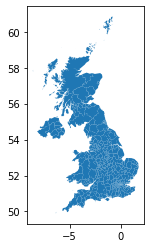

In [4]:
lads = geopandas.read_file("./data/brexit/local_authority_districts.geojson")\
                .set_index('lad16cd')
lads.plot()

merge the spatial data with the brexit vote data.

Use a Spherical Mercator coordinate reference system (CRS)

In [5]:
db = geopandas.GeoDataFrame(lads.join(ref[['Pct_Leave']]), crs=lads.crs)\
              .to_crs(epsg=3857)\
              [['objectid', 'lad16nm', 'Pct_Leave', 'geometry']]\
              .dropna()
db.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 380 entries, E06000001 to W06000023
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   objectid   380 non-null    int64   
 1   lad16nm    380 non-null    object  
 2   Pct_Leave  380 non-null    float64 
 3   geometry   380 non-null    geometry
dtypes: float64(1), geometry(1), int64(1), object(1)
memory usage: 14.8+ KB


here we 

In [6]:
#setup default map args to simplify our plots
map_args = dict(cmap='viridis', 
        scheme='quantiles',
        k=5, 
        edgecolor='white', 
        linewidth=0., 
        alpha=0.75, 
        legend=True,
        legend_kwds={"loc": 2})

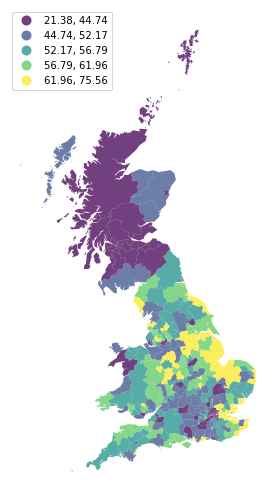

In [7]:
f, ax = plt.subplots(1, figsize=(9, 9))
db.plot(column='Pct_Leave', ax=ax, **map_args)
ax.set_axis_off()

In [8]:
# Generate W from the GeoDataFrame
w = weights.KNN.from_dataframe(db, k=8)
#build the weights matrix from the dataframe using the 8 nearest neighbours

# Row-standardization
w.transform = 'R'

D:\Anaconda\envs\gis\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 6 islands with ids: 46, 52, 331, 339, 342, 358.
  warnings.warn(message)


In [16]:
from pysal.lib import weights
wq = weights.contiguity.Queen.from_dataframe(db)
#ax = db.plot(edgecolor='k', facecolor='w')
wq.plot(db, edge_kws=dict(color='r', linestyle=':', linewidth=1),
        node_kws=dict(marker=''))
ax.set_axis_off()

D:\Anaconda\envs\gis\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 6 islands with ids: 46, 52, 331, 339, 342, 358.
  warnings.warn(message)


KeyError: "None of [Int64Index([3, 47], dtype='int64', name='lad16cd')] are in the [index]"

In [10]:
db['Pct_Leave_lag'] = weights.spatial_lag.lag_spatial(w, db['Pct_Leave'])

Here we plot the lag instead of the actual values. 

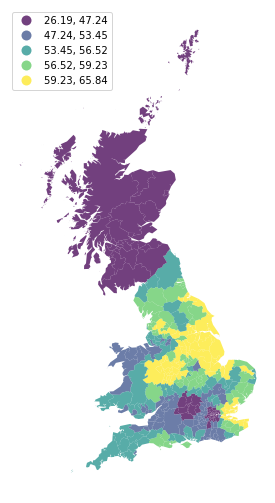

In [11]:
f, ax = plt.subplots(1, figsize=(9, 9))
db.plot(column='Pct_Leave_lag', ax=ax, **map_args)
ax.set_axis_off()

The number of small pockets of "remain" votes disappear in this plot.

The row (E07000148) represents Norwich and (E07000041) represents Exeter, which were both notorious "remainer" island among mostly Leave Norfolk

In [12]:
db.loc[['E07000148', 'E07000041'], ['Pct_Leave', 'Pct_Leave_lag']]

,Pct_Leave,Pct_Leave_lag
lad16cd,,
E07000148,43.76,58.97750
E07000041,44.72,54.79625


We can see with the spatial lag, that the surroudning regions were very different to the cities themselves